<a href="https://colab.research.google.com/github/yoineko/skillfactory-module6/blob/master/Common.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Проверка входных и выходных данных

# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть  и дообучить под нашу задачу. 




In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Aug 26 15:21:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os
from pathlib import Path


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB6, EfficientNetB7, EfficientNetB0
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(DIR + "input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train.gsheet', 'sample-submission.gsheet']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 3 #32 #32 #64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 600 #224 #299 #350 #224 # начнем с малого 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)


PATH = "../working/car/" # рабочая директория
DATA_PATH = DIR + 'input/'

ver = '7_4'

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_PATH,"train.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_PATH,"sample-submission.csv"))
train_df.head()

Id  Category
0  100155.jpg         0
1  100306.jpg         0
2  100379.jpg         0
3  100380.jpg         0
4  100389.jpg         0

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DIR + "/input/"+data_zip,"r") as z:    
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


Пример картинок (random sample)


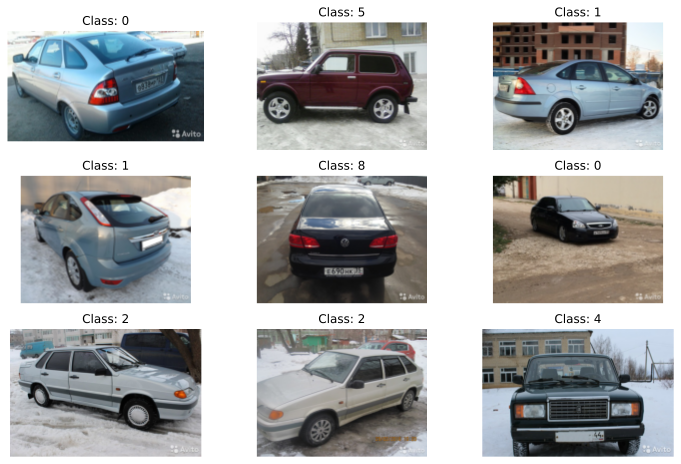

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

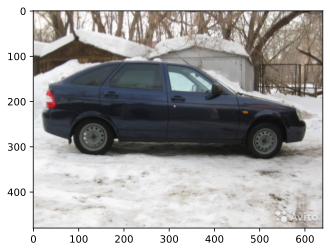

(640, 480)

In [ ]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

### Наша цель предсказать модель автомобиля Лада

# Подготовка данных

### Аугментация данных

In [102]:
# Так как у нас небольшой датасет, то применем к нему аугментацию  данных.
train_datagen = ImageDataGenerator(
  #  rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

test_datagen = ImageDataGenerator(
 #   rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
    )

### Генерация данных

In [103]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


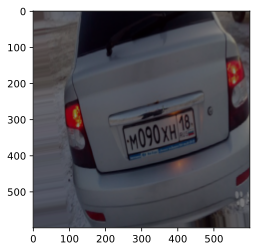

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


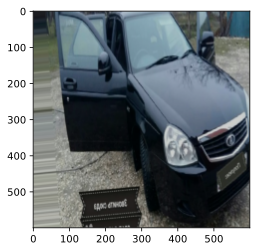

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


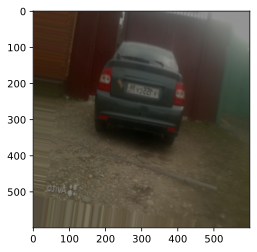

In [105]:
# Проверим, что получилось после работы генераторов
# картинки распознаются 
x_batch, y_batch = next(train_generator)

for i in range (0,BATCH_SIZE):
    print(y_batch[i])
    image = x_batch[i]
    plt.imshow(image.astype(np.uint8))
    plt.show()

# Построение модели

### Загружаем предобученную сеть EfficientNetB7:



In [ ]:
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape, drop_connect_rate=0.4)

258080768/258076736 [==============================] - 4s 0us/step


In [ ]:
# Устанавливаем новую "голову" (head)
base_model.training=False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(100, activation='relu')(x)
x= Dropout(0.2)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
checkpoint = ModelCheckpoint(os.path.join(DIR, f'best_model/best_model{ver}.hdf5') , monitor = 'val_accuracy' , verbose = 1  , save_best_only = True, mode = 'max')
earlystop = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]


In [ ]:
# заморозим BatchNorm слои
for layer in model.layers:
        if  isinstance(layer, BatchNormalization):
            layer.trainable  =  False 
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=["accuracy"])

# Загрузим ранее вычисленные веса
model.load_weights(os.path.join(DIR, f'best_model/best_model7_1.hdf5'))

history =    model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = 1,
        callbacks = callbacks_list
       )
    
    # сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save(os.path.join(DIR, f'working/model_last{ver}.hdf5'))

model.load_weights(os.path.join(DIR, f'best_model/best_model{ver}.hdf5'))


# Проверка модели

In [ ]:
# Проверим точность обученной модели
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy after: %.2f%%" % (scores[1]*100))

777/777 [==============================] - 215s 276ms/step - loss: 0.1671 - accuracy: 0.9729
Accuracy after: 97.29%


In [97]:
# соберем предсказания в формате :картинка, предсказание, истинная метка, вероятность, чтобы в дальнейшем визуализировать 
# wrong - ошибочные предсказания  all_pred - все предсказания
wrong = []
all_pred = []
for i in range(0,len(test_generator)):  
   imgs,labels = test_generator.next()
   pred = model.predict(imgs)
   rounded_pred = np.argmax(pred, axis=-1)
   array_imgs = np.asarray([img_to_array(img) for img in imgs])
   y_true.append(np.argmax(labels, axis=-1))
   y_pred.append(rounded_pred)
   all_pred  += ([im for im in zip(array_imgs, rounded_pred, np.argmax(labels, axis=-1),pred)])
   wrong +=([im for im in zip(array_imgs, rounded_pred, np.argmax(labels, axis=-1),pred) if im[1]!=im[2]])

In [98]:
# Проверим метрики по классам 
y_true = [x[2] for x in all_pred]
y_pred = [x[1] for x in all_pred]

target_names = ['Lada Priora', 'Ford', 'Lada 2113', 'Lada 110', 'Lada 7', 'Lada 2121','Kalina', 'Lada 9', 'Volkswagen', 'Lada 99']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Lada Priora       0.99      0.97      0.98       241
        Ford       0.99      1.00      0.99       295
   Lada 2113       0.98      0.99      0.98       218
    Lada 110       0.97      1.00      0.98       229
      Lada 7       1.00      1.00      1.00       210
   Lada 2121       1.00      0.98      0.99       244
      Kalina       0.99      1.00      0.99       259
      Lada 9       0.91      0.83      0.87       181
  Volkswagen       0.99      1.00      0.99       264
     Lada 99       0.86      0.91      0.89       188

    accuracy                           0.97      2329
   macro avg       0.97      0.97      0.97      2329
weighted avg       0.97      0.97      0.97      2329



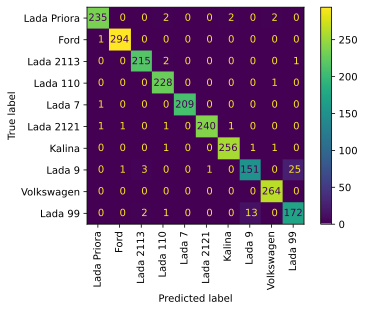

In [ ]:
#Проанализируем  между какими классами чаще всего происходят ошибки
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names).plot(values_format='3d',xticks_rotation='vertical')
plt.show()

Построенная сеть достаточно хорошо определяет модель автомобиля, точность 97%.
Такие модели как Форд , Lada 110, Lada 7, Wolkswagen  предсказаны  с точностью почти  100%.
Чаще всего модель ошибается между моделями Лада 9 и Лада 99, модели очень похожи по дизайну, но и тестовых данных по этим моделям меньше, чем по другим моделям  


## Визуализируем  ошибки 

In [101]:
print(f'Ошибочно классифицированных изображений :{len(wrong)}')
plt.figure(figsize=(20,100))
for ind, val in enumerate(wrong):  
    plt.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace = 0.2, hspace = 0.2)
    plt.subplot(30,4,ind+1)
    plt.axis('off')
    plt.text(320, 0, target_names[np.argmax(val[3])], fontsize=11, color='red')
    plt.text(0, 0, target_names[val[2]], fontsize=11, color='blue')
    plt.imshow(val[0].astype(np.uint8))

Ошибочно классифицированных изображений :64


Можно заметить, что так же есть и  недостатки в тестовом наборе данных: 
1.   неверные метки классов (например - Lada 110 отнесена к Lada 99, грузовик к Lada 9)
2.   На одном изображении могут быть несколько автомоблей
3.   Битые автомобили






# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

6675

In [ ]:
# test_sub_generator.reset()
# predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
# predictions = np.argmax(predictions, axis=-1) #multiple categories
# label_map = (train_generator.class_indices)
# label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
# predictions = [label_map[k] for k in predictions]

In [ ]:
# Test Time Augmentation (TTA)
from tqdm import tqdm

test_sub_generator.reset()
tta_steps = 10
l_predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    l_predictions.append(preds)

pred = np.mean(l_predictions, axis=0)

predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

  0%|          | 0/10 [00:00<?, ?it/s]

2225/2225 [==============================] - 611s 275ms/step


 10%|█         | 1/10 [10:15<1:32:22, 615.89s/it]

2225/2225 [==============================] - 604s 271ms/step


 20%|██        | 2/10 [20:20<1:21:39, 612.48s/it]

2225/2225 [==============================] - 609s 274ms/step


 30%|███       | 3/10 [30:30<1:11:21, 611.65s/it]

2225/2225 [==============================] - 608s 273ms/step


 40%|████      | 4/10 [40:38<1:01:04, 610.80s/it]

2225/2225 [==============================] - 608s 273ms/step


 50%|█████     | 5/10 [50:47<50:50, 610.15s/it]  

2225/2225 [==============================] - 609s 274ms/step


 60%|██████    | 6/10 [1:00:56<40:39, 609.87s/it]

2225/2225 [==============================] - 615s 276ms/step


 70%|███████   | 7/10 [1:11:12<30:35, 611.67s/it]

2225/2225 [==============================] - 606s 273ms/step


 80%|████████  | 8/10 [1:21:19<20:20, 610.28s/it]

2225/2225 [==============================] - 603s 271ms/step


 90%|█████████ | 9/10 [1:31:23<10:08, 608.35s/it]

2225/2225 [==============================] - 610s 274ms/step


100%|██████████| 10/10 [1:41:34<00:00, 609.45s/it]


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(DIR + f'submission/submission_{ver}.csv', index=False)
print('Save submit')


Save submit


In [ ]:
submission.head()

Id Category
0  305108.jpg        7
1  295075.jpg        6
2   31197.jpg        4
3   93598.jpg        7
4   87877.jpg        7